# Emotion Recognition on Twitter

## Table of Contents
1. Read Data
2. Data Exploration: Hashtag>>Emotion
    - Anger Hashtag
    - Anticipation Hashtag
    - Disgust Hashtag
    - Fear Hashtag
    - Sadness Hashtag
    - Surprise Hashtag
    - Trust Hashtag
    - Joy Hashtag
3. Data Exploration: Emoji>>Emotion
4. Bert Model
    - Data preprocessing
    - Using pre-trained words embedding (glove)
    - Bert Model
    - Create submition csv
5. Association Rule by Result with Hashtag, Emoji and Bert Model

In [ ]:
import os
import numpy as np
import pandas as pd
import json 
from sklearn.model_selection import train_test_split
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import FreqDist
import emoji

/Users/jhihchingyeh/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jhihchingyeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(os.path.abspath(os.getcwd()))

/Users/jhihchingyeh/DMLab2/kaggle


In [ ]:
path = "/Users/jhihchingyeh/DMLab2/kaggle/new_hw2/Data_Preprocess/data"

## 1. Read Data

In [ ]:
# Read Data
def read_data(path):
    os.chdir(path)
    # csv
    data_id = pd.read_csv("data_identification.csv") #1867535
    emotion = pd.read_csv("emotion.csv") #1455563
    sampleSubmission = pd.read_csv("sampleSubmission.csv") #411972
    # json
    tweets = []
    for line in open('tweets_DM.json', 'r'):
        line_ = json.loads(line)
        tweets.append(line_)
    # json to dataframe #1867535
    df = pd.DataFrame(columns=['tweet_id','text', 'hashtags'])
    df["tweet_id"] = [tweet["_source"]["tweet"]["tweet_id"] for tweet in tweets]
    df["text"] = [tweet["_source"]["tweet"]["text"] for tweet in tweets]
    df["hashtags"] = [tweet["_source"]["tweet"]["hashtags"] for tweet in tweets]
    return df, data_id, emotion, sampleSubmission

In [ ]:
# Split data into train and test data
def split_data(df, data_id, emotion, sampleSubmission):
    # - train
    train_df = pd.merge(data_id,emotion)
    train_df = pd.merge(train_df,df)
    # - pred
    pred_df = data_id.loc[data_id['identification'] == 'test']
    Submission = sampleSubmission.rename(columns={'id':'tweet_id'})
    Submission = pd.merge(Submission, pred_df)
    pred_df = pd.merge(Submission, df)
    return train_df, pred_df #1455563 #411972

In [ ]:
# Save to csv to save the time next
df, data_id, emotion, sampleSubmission = read_data(path)
train_df, pred_df = split_data(df, data_id, emotion, sampleSubmission)
train_df["emotion_code"] = train_df.emotion.map({"anger":0, "anticipation":1, "disgust":2, "fear":3, "sadness":4, "surprise":5, "trust":6, "joy":7})
pd.DataFrame(train_df).to_csv("train_new.csv", index=False)
pd.DataFrame(pred_df).to_csv("pred_new.csv", index=False)
print(train_df.shape)
print(pred_df.shape)

(1455563, 6)
(411972, 5)


---

## 2. Data Exploration - Hashtag>>Emotion

In [ ]:
# Lower case
def lower_text(text):
    text = text.lower()
    return text

In [ ]:
# Collect the hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [ ]:
# Read and initiate the emotion data
emotion = ["anger", "anticipation", "disgust", "fear", "sadness", "surprise", "trust", "joy"]
train = pd.read_csv('train_new.csv', lineterminator='\n')
test = pd.read_csv('pred_new.csv', lineterminator='\n')
test["emotion"] = 0

In [ ]:
# Lower each word
train.text = train.text.apply(lambda x: lower_text(x))
test.text = test.text.apply(lambda x: lower_text(x))

# Extract hashtags from emotion tweets
HT_anger = hashtag_extract(train['text'][train['emotion_code'] == 0])
HT_anticipation = hashtag_extract(train['text'][train['emotion_code'] == 1])
HT_disgust = hashtag_extract(train['text'][train['emotion_code'] == 2])
HT_fear = hashtag_extract(train['text'][train['emotion_code'] == 3])
HT_sadness = hashtag_extract(train['text'][train['emotion_code'] == 4])
HT_surprise = hashtag_extract(train['text'][train['emotion_code'] == 5])
HT_trust = hashtag_extract(train['text'][train['emotion_code'] == 6])
HT_joy = hashtag_extract(train['text'][train['emotion_code'] == 7])

In [ ]:
# Unnesting list
# It takes a long long time
HT_anger = sum(HT_anger,[])
print("HT_anger finish")
HT_anticipation = sum(HT_anticipation,[])
print("HT_anticipation finish")
HT_disgust = sum(HT_disgust,[])
print("HT_disgust finish")
HT_fear = sum(HT_fear,[])
print("HT_fear finish")
HT_sadness = sum(HT_sadness,[])
print("HT_sadness finish")
HT_surprise = sum(HT_surprise,[])
print("HT_surprise finish")
HT_trust = sum(HT_trust,[])
print("HT_trust finish")
HT_joy = sum(HT_joy,[])
print("HT_joy finish")

HT_anger finish
HT_anticipation finish
HT_disgust finish
HT_fear finish
HT_sadness finish
HT_surprise finish
HT_trust finish
HT_joy finish


### Anger Hashtag

['pissed', 'bb19', 'annoyed', 'frustrated', 'anger', 'mad', 'angry', 'fedup', 'rage', 'ill', 'tired', 'wrath', 'bb19finale', 'pissedoff', 'offended', 'enraged', 'trump', 'football', 'irritated', 'help']


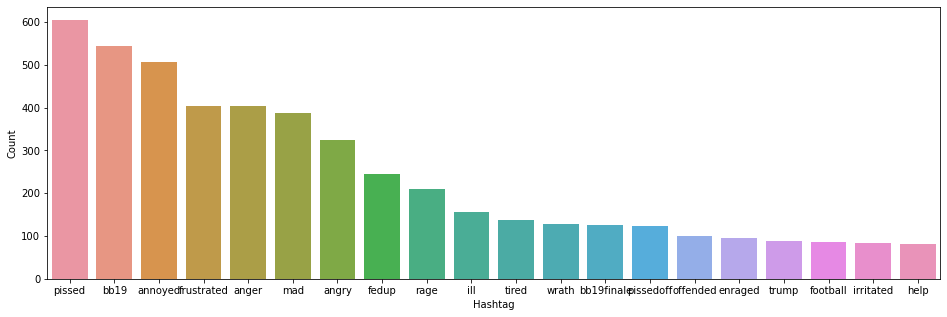

In [ ]:
a = nltk.FreqDist(HT_anger)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
anger_keys = d["Hashtag"].values.tolist()
print(anger_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('anger.png')
plt.show()

### Anticipation Hashtag

['god', 'life', 'dream', 'jesus', 'faith', 'excited', 'pray', 'believe', 'motivation', 'success', 'wisdom', 'trump', 'maga', 'mondaymotivation', 'christ', 'inspiration', 'hungry', 'inspire', 'entrepreneur', 'waiting']


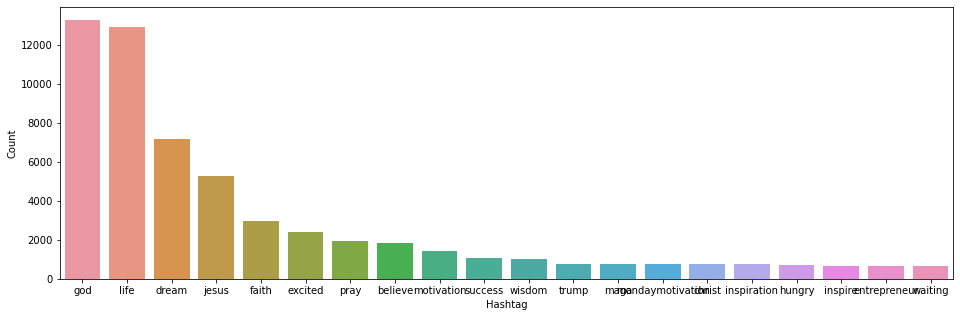

In [ ]:
a = nltk.FreqDist(HT_anticipation)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
anticipation_keys = d["Hashtag"].values.tolist()
print(anticipation_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('anger.png')
plt.show()

### Disgust Hashtag

['wtf', 'shame', 'stupid', 'trump', 'dumb', 'lame', 'bb19', 'gross', 'smh', 'nfl', 'lol', 'maga', 'why', 'nasty', 'resist', 'fail', 'terrible', 'racist', 'charlottesville', 'gameofthrones']


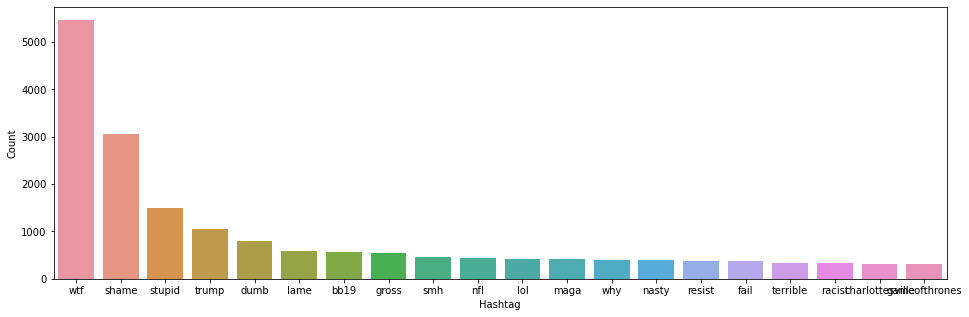

In [ ]:
a = nltk.FreqDist(HT_disgust)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
disgust_keys = d["Hashtag"].values.tolist()
print(disgust_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('anticipation.png')
plt.show()

### Fear Hashtag

['insecure', 'fear', 'jealous', 'halloween', 'power', 'gameofthrones', 'scared', 'nervous', 'anxiety', 'got', 'spooky', 'treats', 'life', 'worried', 'courage', 'success', 'scary', 'trump', 'anxious', 'overwhelmed']


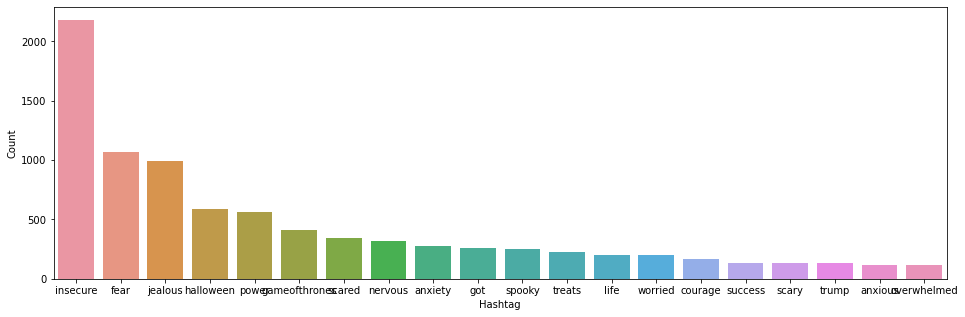

In [ ]:
a = nltk.FreqDist(HT_fear)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
fear_keys = d["Hashtag"].values.tolist()
print(fear_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('fear.png')
plt.show()

### Sadness Hashtag

['sad', 'confused', 'trump', 'disappointed', 'maga', 'awkward', 'broken', 'blue', 'faketweets', 'guilty', 'alone', 'useless', 'life', 'help', 'stressed', 'broke', 'down', 'impeachtrump', 'fail', 'resist']


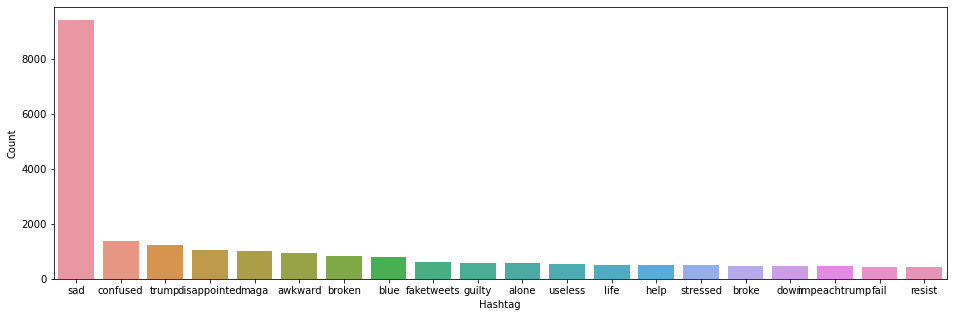

In [ ]:
a = nltk.FreqDist(HT_sadness)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
sadness_keys = d["Hashtag"].values.tolist()
print(sadness_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('sadness.png')
plt.show()


### Surprise Hashtag

['crazy', 'lost', 'weird', 'ass', 'surprise', 'pussy', 'trump', 'shocked', 'girls', 'distraction', 'different', 'strange', 'dm', 'snapchat', 'impressed', 'dick', 'tits', 'life', 'porn', 'naughty']


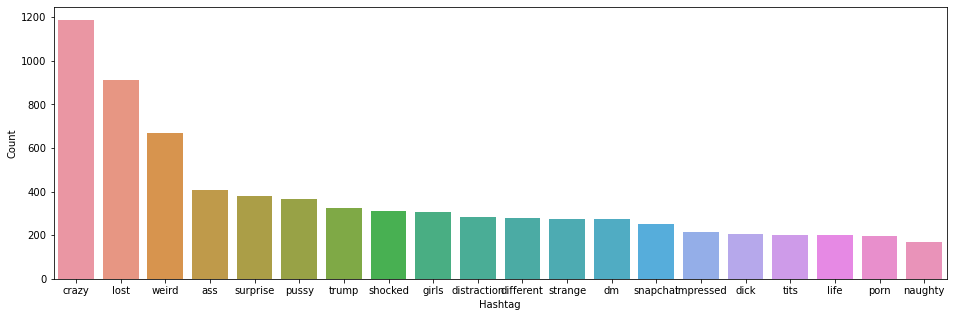

In [ ]:
a = nltk.FreqDist(HT_surprise)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
surprise_keys = d["Hashtag"].values.tolist()
print(surprise_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('surprise.png')
plt.show()

### Trust Hashtag

['life', 'grateful', 'thankful', 'proud', 'hope', 'thanks', 'help', 'followers', 'trust', 'pride', 'gratitude', 'today', 'motivation', 'healthy', 'inspiration', 'success', 'safe', 'inspired', 'health', 'cute']


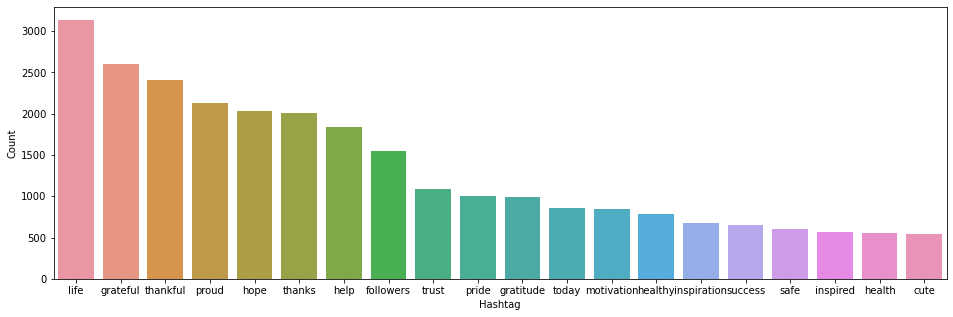

In [ ]:
a = nltk.FreqDist(HT_trust)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
trust_keys = d["Hashtag"].values.tolist()
print(trust_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('trust.png')
plt.show()

### Joy Hashtag

['love', 'blessed', 'life', 'special', 'everyday', 'happy', 'awesome', 'female', 'faith', 'hope', 'amazing', 'content', 'beautiful', 'thanks', 'motivation', 'inspiration', 'success', 'joy', 'perfect', 'world']


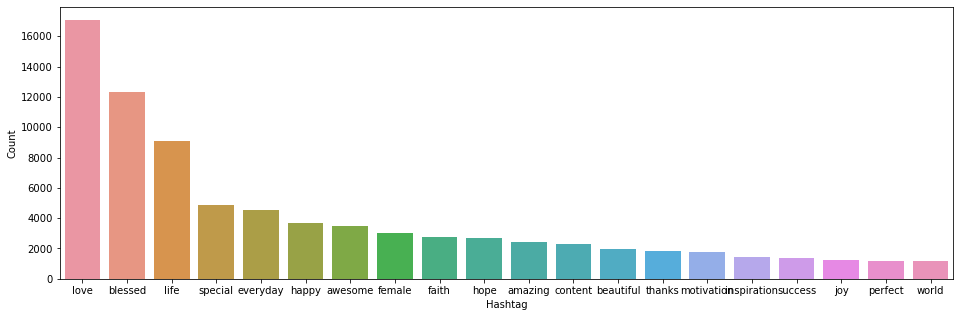

In [ ]:
a = nltk.FreqDist(HT_joy)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
joy_keys = d["Hashtag"].values.tolist()
print(joy_keys)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.savefig('joy.png')
plt.show()

HT_test = hashtag_extract(test['text'])

In [ ]:
for i in range(len(HT_test)):
    sameNum_emotion = []
    # anger
    sameTerm = [l for l in anger_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # anticipation
    sameTerm = [l for l in anticipation_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # disgust
    sameTerm = [l for l in disgust_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # fear
    sameTerm = [l for l in fear_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # sadness
    sameTerm = [l for l in sadness_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # surprise
    sameTerm = [l for l in surprise_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # trust
    sameTerm = [l for l in trust_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    # joy
    sameTerm = [l for l in joy_keys if l in HT_test[i]]
    sameNum = len(sameTerm)
    sameNum_emotion.append(sameNum)
    
    n = 0
    MAX = max(sameNum_emotion)
    if MAX != 0:
        #print(i, sameNum_emotion)
        for j in range(8):
            if sameNum_emotion[j] == MAX:
                n +=1
        if n == 1:
            index = sameNum_emotion.index(MAX)
            test.loc[i, "emotion"] = emotion[index]
            #print(emotion[index])

In [ ]:
print("test.shape: ", test.shape)
test.to_csv("test_hashtag.csv", index=False)

print("len of test[test['emotion'] != 0]: ", len(test[test['emotion'] != 0])) #7009

test.shape:  (411972, 5)
len of test[test['emotion'] != 0]:  7009


---

## 3. Data Exploration - Emoji>>Emotion

In [ ]:
!pip install emoji

In [ ]:
# Take a look for emoji list 
emoji_list = [v for k,v in emoji.EMOJI_UNICODE['en'].items()] #3633
print(emoji_list[:10])

['🥇', '🥈', '🥉', '🆎', '🏧', '🅰️', '🇦🇫', '🇦🇱', '🇩🇿', '🇦🇸']


In [ ]:
# Program is too large, so I ran it on the server after object 10
# Build df_emoji to store what emotion is the sentiment of the data containing the emoji in each row

df_emoji = pd.DataFrame(columns = ["emoji", "emotion", "emoji_ans", "len"])

n = 0
for emoji in emoji_list:
    empty = True
    emoji_emotion = []
    for i in range(len(train)):
        t = train.loc[i, "text"]
        if emoji in t:
            empty = False
            emoji_emotion.append(train["emotion"][i])
    if empty == False:
        df_emoji=df_emoji.append({'emoji' : emoji , 'emotion' : emoji_emotion}, ignore_index=True)
        # Try 10 emoji to show what I did, and the others is run on server
        if n < 10:
            print(emoji, emoji_emotion)
            break

🥇 ['joy', 'sadness', 'trust', 'trust', 'joy', 'joy', 'trust', 'disgust', 'anticipation', 'joy', 'trust', 'joy', 'anticipation', 'anticipation', 'trust', 'trust', 'joy', 'joy', 'anticipation', 'trust', 'joy', 'trust', 'trust', 'trust', 'anticipation', 'trust', 'joy', 'trust', 'joy', 'joy', 'trust', 'trust', 'trust', 'joy', 'trust', 'joy', 'trust', 'trust', 'joy', 'anticipation', 'joy', 'disgust', 'joy', 'joy', 'joy', 'trust', 'anticipation', 'trust', 'trust', 'anticipation', 'trust', 'trust', 'joy', 'trust', 'anticipation', 'trust', 'trust', 'joy', 'joy', 'trust', 'surprise', 'joy', 'joy', 'joy', 'trust', 'trust', 'joy', 'trust', 'trust', 'joy', 'trust', 'trust', 'anticipation', 'trust', 'anticipation', 'joy', 'joy', 'trust', 'joy', 'joy', 'anticipation', 'surprise', 'anticipation', 'anticipation', 'anticipation', 'joy', 'joy', 'joy', 'joy', 'trust', 'joy', 'trust', 'anticipation', 'joy', 'trust', 'anticipation', 'trust', 'trust', 'joy', 'joy', 'trust', 'joy', 'joy', 'joy', 'joy', 'trus

In [ ]:
# Delete the emoji only appear once
df_emoji = df_emoji[df_emoji["len"] != 1].reset_index(drop=True)

In [ ]:
# Categorize emoji into various emotions
for i in range(len(df_emoji)):
    maxNum = 0
    emotionAppNum = [0,0,0,0,0,0,0,0]
    emo_kind = df_emoji.loc[i,"emotion"]
    for j in range(len(emo_kind)):
        for k in range(8):
            if emo_kind[j] == emotion[k]:
                emotionAppNum[k] +=1
    if max(emotionAppNum) > 1:
        for m in range(8):
            if emotionAppNum[m] == max(emotionAppNum):
                maxNum +=1
    if maxNum == 1:
        index_ = emotionAppNum.index(max(emotionAppNum))
        emojiEmotion = emotion[index_] #ans
        df_emoji.loc[i, "emoji_ans"] = emojiEmotion
        print(df_emoji["emoji"][i], emojiEmotion)

🥇 joy


In [ ]:
df_emoji.head()

,emoji,emotion,emoji_ans,len
0,🥇,"[joy, sadness, trust, trust, joy, joy, trust, ...",joy,NaN


In [ ]:
df_emoji.to_csv("df_emoji.csv", index=False)

---

## 4. Bert Model
(Program is too large, so I ran it on the server)

### a. Data preprocessing

In [ ]:
# Replace some special text by regularize words
# EX: @ERIC ===> USER
# EX: 25 times ===> NUM times

emailsRegex = re.compile(r'[\w\.-]+@[\w\.-]+')
userMentionsRegex = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)')
urlsRegex = re.compile('r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+')
numsRegex = re.compile(r"\b\d+\b")

texts = train_data['text']
start = time.time()
texts = texts.apply(lambda a:a.replace("<LH>",""))
texts = texts.apply(lambda a:userMentionsRegex.sub(' USER',a))
texts = texts.apply(lambda a:emailsRegex.sub(' EMAIL',a))
texts = texts.apply(lambda a:urlsRegex.sub(' URL',a))
texts = texts.apply(lambda a:numsRegex.sub(' NUM',a))

In [ ]:
texts = list(train['text'])
labels = list(train['emotion_code'])

In [ ]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [ ]:
max_len=60 
data = pad_sequences(sequences, maxlen=max_len)
print('data shape:', data.shape)

In [ ]:
# Split the data
x_train,x_test,y_train,y_test = train_test_split(data, label, test_size=0.25, random_state=20191118)

### b. Using pre-trained words embedding (glove)

In [ ]:
EMBEDDING_DIM = 100
 
embeddings_index = {}
f = open(r'glove.twitter.27B.100d.txt',encoding="utf-8")
print("Loading GloVe")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print("Done.\nProceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # Words not found in embedding index will be all-zeros.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

### c. Bert Model

In [ ]:
# the best result is 0.469
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm1 = Bidirectional(LSTM(70,dropout=0.4,recurrent_dropout=0.4,return_sequences=True))(embedded_sequences)
l_cov1= Conv1D(100, 3, activation='relu',kernel_regularizer=regularizers.l2(0.02))(l_lstm1)
l_pool1 = MaxPooling1D(2)(l_cov1)
l_drop1 = Dropout(0.4)(l_pool1)
l_flat = Flatten()(l_drop1)
l_dense = Dense(50, activation='relu')(l_flat)
preds = Dense(8, activation='softmax')(l_dense)

model = Model(sequence_input,preds)
adam= optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
#adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

In [ ]:
epoch = 5
batch_size = 500

In [ ]:
# Only save the best model.
path = "model/best.h5"
checkpoint = callbacks.ModelCheckpoint(path, monitor='val_acc',verbose=1, save_best_only=True)
csv_logger = callbacks.CSVLogger("model/model_history.csv", separator=',',append=True)

In [ ]:
train_history =model.fit(x_train, y_train, validation_data=(x_test, y_test),
                         epochs=epoch, batch_size=batch_size,callbacks=[checkpoint,csv_logger])

In [ ]:
#Plot the Loss/Acc 
import matplotlib.pyplot as plt 
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### d. Create submition csv

In [ ]:
texts = list(test_data['text'])
test_sequences = tokenizer.texts_to_sequences(texts)
test = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model = load_model('model/best.h5')
predict = model.predict(test,batch_size=batch_size)
pre = np.argmax(predict, axis=1)
result = label_encoder.inverse_transform(pre)
test_data['emotion'] = result
test_data=test_data.drop(['identification','text'],axis=1)
Submission['emotion']=test_data['emotion']
Submission.to_csv('result.csv')

---

## 5. Association Rule by Result with Hashtag, Emoji and Bert Model

In [ ]:
# Read all data above
naive_bayes = pd.read_csv(r"result/result_0.5.csv", lineterminator='\n')
hashtag = pd.read_csv(r"result/test_hashtag.csv", lineterminator='\n')
emoji = pd.read_csv(r"result/test_emoji.csv", lineterminator='\n')

In [ ]:
print(naive_bayes.shape)
print(hashtag.shape)
print(emoji.shape)

(411972, 2)
(411972, 5)
(411972, 7)


In [ ]:
# Rename
hashtag = hashtag.rename(columns={'tweet_id':'id'})
hashtag = hashtag.rename(columns={'emotion':'hashtag_emo'})
emoji = emoji.rename(columns={'tweet_id':'id'})
emoji = emoji.rename(columns={'emotion':'emoji_emo'})

In [ ]:
# Check the id is the same
for i in range(411972):
    if naive_bayes["id"][i] != hashtag["id"][i]:
        print("error: ", i)
    if naive_bayes["id"][i] != emoji["id"][i]:
        print("error: ", i)
    if hashtag["id"][i] != emoji["id"][i]:
        print("error: ", i)

In [ ]:
# Merge them into one df
df = pd.merge(naive_bayes, hashtag)
df["emoji_emo"] = emoji["emoji_emo"]

In [ ]:
df.head()

,id,emotion,hashtag_emo,identification,text,hashtags,emoji_emo
0,0x2c7743,joy,0,test,when your friends offer to bring you food 😭💘 #...,"['loyal', 'real']",joy
1,0x2c1eed,joy,0,test,i've never let any money problems stop me.. i ...,[],joy
2,0x2826ea,sadness,0,test,@kurtschlichter being a hobby historian chelse...,[],0
3,0x356d9a,joy,0,test,#cannabis offers a natural alternative treatme...,"['Cannabis', 'Marijuana', 'Weed', 'Hemp', 'Med...",0
4,0x20fd95,joy,0,test,last friday off before school starts. i'm read...,['FridayFeeling'],0


In [ ]:
# Double Check by emoji, hashtag and Bert Model
num = 0
for i in range(len(df)):
    # if we set up the relation between this "emoji" to the emotion
    if df["emoji_emo"][i] != "0":
        # if the result predicted by emoji is different from by bert model
        if df["emotion"][i] != df["emoji_emo"][i]:
            # if we set up the relation between this "hashtag" to the emotion
            if df["hashtag_emo"][i] != "0":
                # if the result predicted by hashtag is different from by bert model
                if df["emotion"][i] != df["hashtag_emo"][i]:
                    # if the result predicted by emoji is the same with by hashtag
                    if df["emoji_emo"][i] == df["hashtag_emo"][i]:
                        # Change to the this answer
                        df.loc[i, "emotion"] = df["emoji_emo"][i]
                        num +=1
                        
print("Modify: ", num)

Modify:  19


In [ ]:
df[["id", "emotion"]].to_csv("final_result.csv", index=False)